<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 4

## Q1:Discrete FFT and Power Spectrum

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
%matplotlib nbagg
%matplotlib inline

hourdata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/AllHourly.txt')[[6,28],2:]
dc = hourdata[0,:]
jb=hourdata[1,:]

**1** Using the data from the hourly time series at Deep Cove (`dc`), show that the canned `fft` routine returns the correct discrete Fourier Transform of a suitable subset of the data (your choice on what subset).  You can do this graphically, by comparing the amplitude and the phase of the Fourier components, or simply show that the resulting numbers are the same.  

Some Hints: 
  - ignore bad data (rather than dealing with it "properly").  Make sure the units of your FT are: $\mathrm{^oC\, s}$.
  - If you want to compute the DFT efficiently, form the matrix $F$ referred to in the notes, and plot some of the time series associated with the different entries and make sure they look like Sines and Cosines and that the edge conditions are what you want.  Alternately, you can use your dft routine from the last assignment, and chose your frequencies properly.


In [71]:
# Digital Fourier Transform
def dft(x,dt,f):
    t = dt*np.arange(0,len(x))
    T,F=np.meshgrid(t,f)
    
    # make the fourier matrices
    E = np.exp(-1j*2*np.pi*T*F)
    X = dt*np.dot(E,x)
    
    return X

359
(0.999999999999+0j)


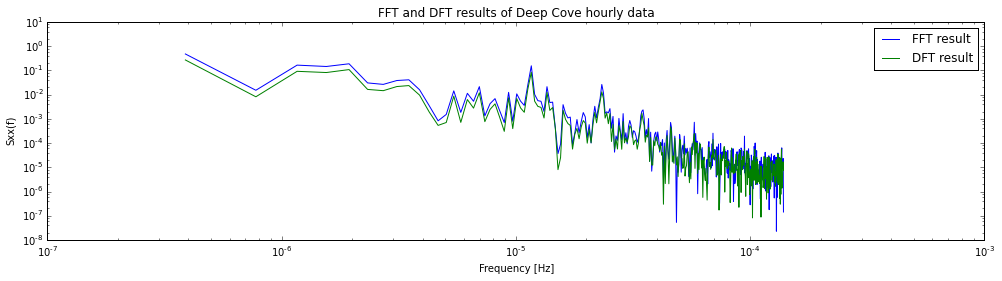

In [109]:
# take a 30 day subset of the data
dc_new = dc[0:24*30]

# remove the non-numerical data
dc_new = dc_new[~np.isnan(dc_new)]

# take the FFT using the canned routine
DC_fft = np.fft.fft(dc_new)

# create the array of frequencies to use in plotting
dt = 3600 # seconds in 1 hour
N = len(dc_new) # data points
T = dt*N

frequencies = np.linspace(0,(1./(2.*dt)),N/2+1)

print len(frequencies)
        
# take the DFT using an explicitly written function
DC_dft = dft(dc_new,dt,frequencies)

# take the Spectrum Densities
Sxx_dft = DC_dft*np.conj(DC_dft)/T/11458226.5003
DC_fft_cut = DC_fft[:len(frequencies)]
Sxx_fft = 2.*DC_fft_cut*np.conj(DC_fft_cut)/T

# plot the results
plt.figure(figsize=(14,4))       # Make figure
gs=gridspec.GridSpec(1,1)        # Set up the layout
ax=plt.subplot(gs[0:1])          # select the whole grid to plot in
ax.plot(frequencies,Sxx_fft,label='FFT result')  # plot
ax.plot(frequencies,Sxx_dft,label='DFT result')  # plot
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Sxx(f)')
ax.legend()   # label
ax.loglog()
ax.set_title('FFT and DFT results of Deep Cove hourly data')

#print Sxx_dft[100]/Sxx_fft[100]

# tighten the layout a bit
plt.tight_layout()

As can be see from above, the Spectrum results from using the canned FFT routine and from using the explicit DFT routine have an identical pattern. Their magnitudes different by a constant factor, which when removed, shows nearly idential lines on the graph. Therefore, we can use numpy.fft.fft and believe in it's results.

**2** Now, we can go ahead and use `np.fft.fft`.  Estimate the power spectrum for the Deep Cove time series (again go ahead and skip over gaps, though some of the bigs ones will screw up your frequencies a bit)

  - Use *all* the data.  
  - Report your results in proper SI units.
  - Indicate on your plot at least a couple of important frequencies

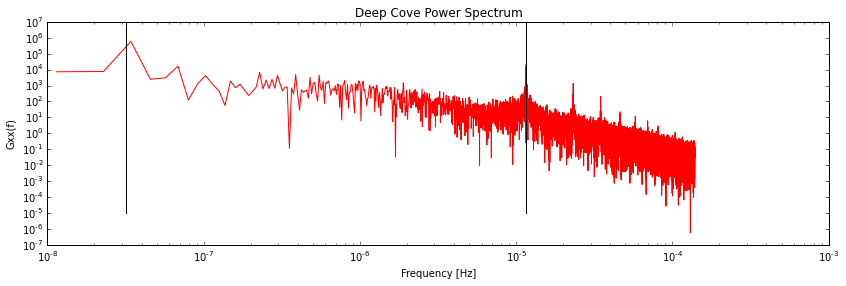

In [73]:
dc_real = dc[~np.isnan(dc)]
dc_real = dc_real

# create the array of frequencies to use in plotting
dt = 3600 # seconds in 1 hour
N = len(dc_real) # data points
T = dt*N
frequencies = np.linspace(0,(1./(2.*dt)),N/2+1)

freq = frequencies 

DC = np.fft.fft(dc_real)
Sxx = np.abs(DC)**2/len(DC)
Gxx = 2.*Sxx

Gxx = Gxx[:len(freq)]

plt.figure(figsize=(14,4))       # Make figure
gs=gridspec.GridSpec(1,1)        # Set up the layout
ax=plt.subplot(gs[0:1])          # select the whole grid to plot in
ax.plot(freq,Gxx,color='red')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Gxx(f)')
ax.set_title('Deep Cove Power Spectrum')
ax.loglog()

# Point out the important frequencies
f1 = 1./(24.*3600.) # daily
f2 = 1./(24.*3600.*365.25) # yearly
g1 = 10e-6
g2 = 10e6
plt.plot((f1, f1), (g1, g2), 'k-')
plt.plot((f2, f2), (g1, g2), 'k-')

The important frequencies are found by observing local maxima. 
Two noteable frequencies are (1/(24 x 3600)) Hz which corresponds to the daily frequency, and (1/(24 x 3600 x 365.25)) Hz which corresponds to the yearly frequency. 

**3** Demonstrate Parceval's Theorem applies to your spectral estimate.  i.e. show that 

\begin{equation}
  \sigma_x^2=\int_0^{\infty} G_{xx}(f)\ \mathrm{d}f
\end{equation}

applies to your estimate of $G_{xx}(f)$.

In [74]:
# Caluclate the Right Hand Side
df = 1./3600 # due to hourly data
Rxx = np.mean((dc_real-np.mean(dc_real))*(dc_real-np.mean(dc_real)))
Integral = Rxx

# Calculate the Left Hand Side
Sigma_squared = np.var(dc_real)

print 'Sigma squared = ',Sigma_squared
print 'Integral = ',Integral

Sigma squared =  36.8172572917
Integral =  36.8172572917


-> Since the left hand side (36.817) and the right hand side (36.817) of the formula are very close for our estimate of Gxx(f), we can see that Parceval's Theorem applies to our spectral estimate. Note that to solve the integral on the right hand side, we take the fact from the 3rd lecture which states Rxx(0) = 'The integral'.

## Q2: Emperically derive distribution of spectral estimate

**1** Write a short function to create a "red" time series by taking the cumulative sum of Normally distributed random data, and plot one realization.  The number of data points $N$ can be relatively small (say 1000).

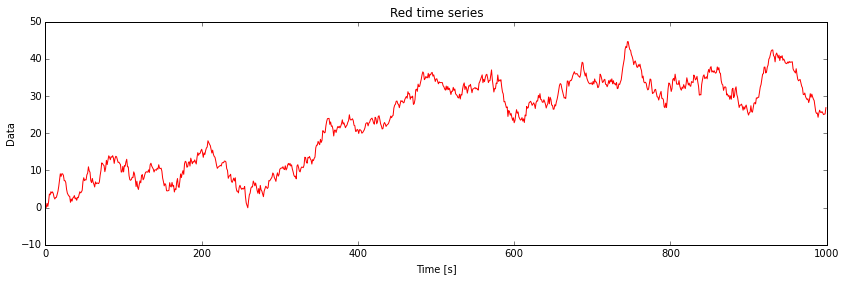

In [98]:
# function to create red time series
def red(N):
    # create data
    data = np.random.normal(0,1,N)
    data = np.cumsum(data)
    time = np.arange(N)
    
    return time,data

# function to plot red time series
def plotRed(t,x):
    plt.figure(figsize=(14,4))       # Make figure
    gs=gridspec.GridSpec(1,1)        # Set up the layout
    ax=plt.subplot(gs[0:1])          # select the whole grid to plot in
    ax.plot(t,x,color='red')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Data')
    ax.set_title('Red time series')

# test the functions
time,data = red(1000)
plotRed(time,data)


**2** Write a second function to return the estimate of the power spectrum of $x$.  For posterity sake, include a value of the sampling frequency, and return the proper frequencies for the estimate.  Plot the resulting spectrum.

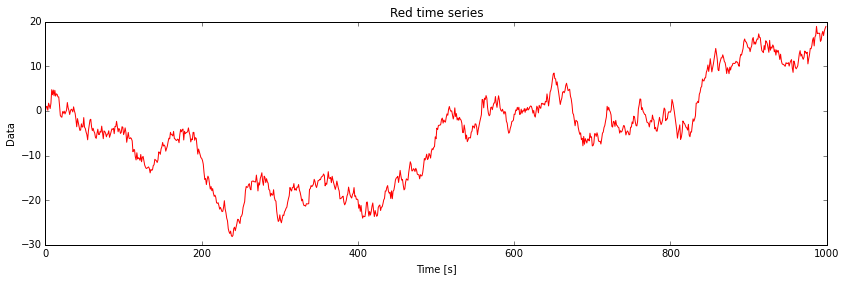

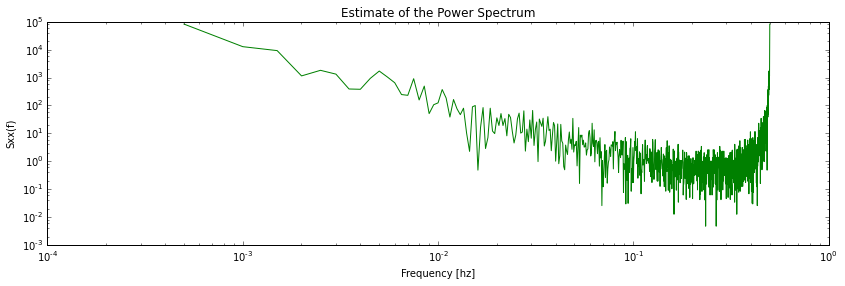

In [102]:
# function to create the spectrum estimate
def spectrum(series):
    fs = 0.5
    frequency = np.linspace(0.,fs,1000)
    
    X = np.fft.fft(series)
    frequencies = np.fft.fftfreq(len(series),1.)
    T = len(series)
    Gxx = 2.*X*np.conj(X)/T

    return frequency,Gxx

# function to plot the spectrum estimate
def plotSpectrum(f,s):
    plt.figure(figsize=(14,4))       # Make figure
    gs=gridspec.GridSpec(1,1)        # Set up the layout
    ax=plt.subplot(gs[0:1])          # select the whole grid to plot in
    ax.plot(f,s,color='green')
    ax.set_xlabel('Frequency [hz]')
    ax.set_ylabel('Sxx(f)')
    ax.set_title('Estimate of the Power Spectrum')
    ax.loglog()

# test the function
time,data = red(1000)
frequency,Gxx = spectrum(data)
plotRed(time,data)
plotSpectrum(frequency,Gxx)

**3** Now do the Monte-Carlo, by running the above 100 times and plotting the resulting spectral estimates as dots on the same plot. As you are making your data, save it into an array.  I did something like:
```python
    Gxs = zeros((1000,501))
    # inside my loop:
        Gxs[ind,:]=Gxx   
```

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


[]

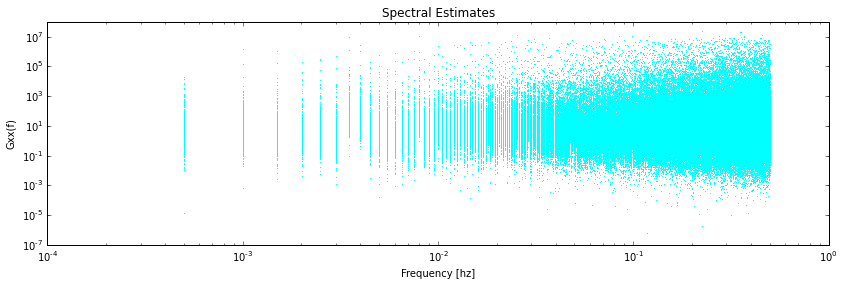

In [103]:
# Monte Carlo function
def montecarlo(N):
    estimates = np.zeros(1000)
    
    Gxs = np.zeros((1000,501))
    #frequency1 = 1 # Hz
    freq = np.zeros(1000)
    
    for i in range(N):
        time,data = red(1000)
        freq,Sxx = spectrum(data)#,frequency1)
        Gxx = 2.*Sxx[:501]
        Gxs[i,:] = Gxx
        
    return freq,Gxs

# test the function
freq,estimates = montecarlo(1000)
plt.figure(figsize=(14,4))       # Make figure
gs=gridspec.GridSpec(1,1)        # Set up the layout
ax=plt.subplot(gs[0:1])          # select the whole grid to plot in

for i in range()
ax.plot(freq,estimates,'k,',color='cyan')
ax.set_xlabel('Frequency [hz]')
ax.set_ylabel('Gxx(f)')
ax.set_title('Spectral Estimates')
ax.loglog()

**4** Now, on the same plot, add the mean of all your $G_{xx}(f)$ estimates (as a function of $f$), and the upper and lower bounds encompasing 95% of the data. (Hint, sort each column of your matrix - `np.sort` - and plot the value at $0.025 N$ and $0.975 N$).


501
501
501


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


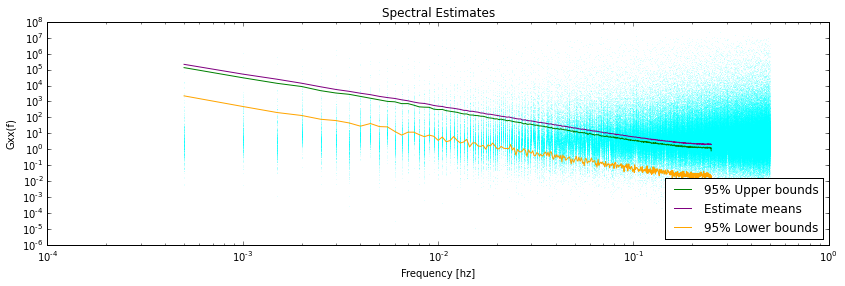

In [104]:
# fucntion to get means as a function of frequency
def getMeans(Gxs):
    N = len(Gxs)
    means = np.zeros(N)
    
    Gxs_transposed = np.transpose(Gxs)
    
    for i in range(N/2+1):
        means[i] = np.mean(Gxs_transposed[i])
    
    return means

# function to get lower bounds for 95% of the data
def getLowerBounds(Gxs):
    N = len(Gxs)
    M = len(Gxs[0])
    lower = np.zeros(N)
    index = int(0.025*M)
    
    Gxs_sorted = np.sort(Gxs, axis=0)
    
    lower = Gxs_sorted[index]
        
    return lower

# function to get upper bounds for 95% of the data
def getUpperBounds(Gxs):
    N = len(Gxs)
    M = len(Gxs[0])
    upper = np.zeros(N)
    index = int(0.975*M)
    
    Gxs_sorted = np.sort(Gxs, axis=0)
    
    upper = Gxs_sorted[index]
        
    return upper

# call the functions and plot
freq,estimates = montecarlo(1000)
means = getMeans(estimates)
lower = getLowerBounds(estimates) 
upper = getUpperBounds(estimates)

plt.figure(figsize=(14,4))       # Make figure
gs=gridspec.GridSpec(1,1)        # Set up the layout
ax=plt.subplot(gs[0:1])          # select the whole grid to plot in
ax.plot(freq,estimates,'k,',color='cyan',alpha=.1)

freq = freq[:len(lower)]
means = means[:len(lower)]

print len(freq)
print len(lower)
print len(upper)

ax.plot(freq,upper,color='green',label='95% Upper bounds')
ax.plot(freq,means,color='purple',label='Estimate means')
ax.plot(freq,lower,color='orange',label='95% Lower bounds')

ax.set_xlabel('Frequency [hz]')
ax.set_ylabel('Gxx(f)')
ax.set_title('Spectral Estimates')
ax.loglog()
ax.legend(loc=4)

YOUR ANSWER HERE

**5** Show that the ratio of the lower and upper bounds of your spectral estimates spread compares favourably with the ratio between the lower and upper 95% confidence bounds of the  $\chi^2_2$ distribution.  Comment on any difference.

In [92]:
inter = stats.chi2.interval(0.95,df=2)
print inter

# Calculate the Chi-squared bounds
chiLow = 2.*means/inter[1]
chiHigh = 2.*means/inter[0]

chiLow = inter[0]
chiHigh = inter[1]

# Calculate the ratios
chiRat = chiHigh/chiLow
estimateRat = np.mean(upper)/np.mean(lower)

print chiRat
print estimateRat

(0.050635615968579753, 7.3777589082278707)
145.702955659
193.384380335


The ratio of Chi-Squared upper and lower bounds was found to be 145.7, and the ratio of upper and lower bounds from our estimates was found to be 193.4. These ratios are fairly similar to each other, which leads us to believe they comnpare favorably. The difference is probably due to the fact that we left out all "not-a-number" values from our data rather than dealing with it properly.